In [1]:
from common.data_frame_columns import TIMESTAMP
from common.data_frame_columns import PM10, PM2_5, PM1
from common.date_time_helper import convert_to_datetime
from common.endpoints_urls import endpoints_config
from data_management.data_crawler import DataManager
from data_management.labeled_data_generator import LabeledDataGenerator, DataLabel

In [2]:
date_strings = ['01.01.2021 00:00', '31.12.2023 23:59']
test_dates_string = ['01.01.2024 00:00', '30.04.2024 23:59']

training_dates = [convert_to_datetime(date_strings[0]), convert_to_datetime(date_strings[1])]
test_dates = [convert_to_datetime(test_dates_string[0]), convert_to_datetime(test_dates_string[1])]

datas = DataManager(True).get_all_endpoints_data(endpoints_config, update=False)

column = PM10
L = LabeledDataGenerator(column)

test_data = L.generate_labeled_data(datas[:1], test_dates[0], test_dates[1], 50, 60)
# single_data = L.generate_labeled_data(datas[:1], training_dates[0], training_dates[1], 40)
# multi_data = L.generate_labeled_data(datas, training_dates[0], training_dates[1], 40)

Loading station data: Gronie  https://datahub.ki.agh.edu.pl/api/endpoints/70/data/
    # Minimal data: 2022-07-13 23:38:02+00:00
    # Maximal data: 2024-05-10 16:16:39+00:00
Loading station data: Urząd Gminy  https://datahub.ki.agh.edu.pl/api/endpoints/71/data/
    # Minimal data: 2023-10-28 07:17:18+00:00
    # Maximal data: 2024-05-10 16:15:37+00:00
Loading station data: Młynne  https://datahub.ki.agh.edu.pl/api/endpoints/72/data/
    # Minimal data: 2022-02-12 21:11:18+00:00
    # Maximal data: 2024-05-10 16:15:59+00:00
Loading station data: Sucharskiego  https://datahub.ki.agh.edu.pl/api/endpoints/73/data/
    # Minimal data: 2021-10-07 19:41:43+00:00
    # Maximal data: 2024-05-10 16:19:11+00:00
Loading station data: Twardowskiego  https://datahub.ki.agh.edu.pl/api/endpoints/74/data/
    # Minimal data: 2021-10-07 20:59:56+00:00
    # Maximal data: 2024-05-10 16:20:04+00:00
Loading station data: Konopnickiej  https://datahub.ki.agh.edu.pl/api/endpoints/75/data/
    # Minimal data

In [3]:
from collections import Counter
from detectors.z_score_detector import ZScoreDetector
import pandas as pd

column = PM10
thresholds = [1.0, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


def debug_print(threshold, correct_anomaly, anomaly, normal, wrong_predicted):
    print(
        f'    [Threshold: {threshold}] Anomaly: {correct_anomaly}/{anomaly} ({round(correct_anomaly / anomaly * 100, 2)}) | Normal {round(correct_normal / normal * 100, 2)} | {round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)}%')

    # counted_values = Counter(wrong_predicted)
    # # Print the counts
    # for value, count in counted_values.items():
    #     print(f"{value}: {count}")


final_results = []

#single sensor detection
name = 'MAD_sensor_level'

zscore = ZScoreDetector()
wrong_predicted = []
mid_results = []
print(f'{name}:')
for threshold in thresholds:
    correct_anomaly = 0
    correct_normal = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_mad(dataframe, column, start_time, end_time, threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    correct_anomaly += 1
                else:
                    wrong_predicted.append(label)
            if label.value == 0:
                normal += 1
                if (len(outliers) < 5):
                    correct_normal += 1

    debug_print(threshold, correct_anomaly, anomaly, normal, wrong_predicted)
    mid_results.append([name, threshold, round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)

wrong_predicted = []
name = 'AVG_sensor_level'
print(f"{name}:")
mid_results = []
for threshold in thresholds:
    correct_anomaly = 0
    correct_normal = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_avg(dataframe, column, start_time, end_time, threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    correct_anomaly += 1
                else:
                    wrong_predicted.append(label)
            if label.value == 0:
                normal += 1
                if (len(outliers) < 5):
                    correct_normal += 1

    debug_print(threshold, correct_anomaly, anomaly, normal, wrong_predicted)
    mid_results.append([name, threshold, round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)

name = 'MAD_network_level'
wrong_predicted = []
mid_results = []
print(f"{name}:")
for threshold in thresholds:
    correct_anomaly = 0
    correct_normal = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_mad_network_level(datas, dataframe, column, start_time, end_time,
                                                                    threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    correct_anomaly += 1
                else:
                    wrong_predicted.append(label)
            if label.value == 0:
                normal += 1
                if (len(outliers) < 5):
                    correct_normal += 1

    debug_print(threshold, correct_anomaly, anomaly, normal, wrong_predicted)
    mid_results.append([name, threshold, round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)

wrong_predicted = []
name = 'AVG_network_level'
mid_results = []
print(f"{name}")
for threshold in thresholds:
    correct_anomaly = 0
    correct_normal = 0
    anomaly = 0
    normal = 0
    for dataframe, label in test_data:
        if not dataframe.empty:
            start_time = dataframe[TIMESTAMP].min()
            end_time = dataframe[TIMESTAMP].max()
            outliers = ZScoreDetector().detect_by_avg_network_level(datas, dataframe, column, start_time, end_time,
                                                                    threshold)
            if label.value > 0:
                anomaly += 1
                if (len(outliers) > 5):
                    correct_anomaly += 1
                else:
                    wrong_predicted.append(label)
            if label.value == 0:
                normal += 1
                if (len(outliers) < 5):
                    correct_normal += 1

    debug_print(threshold, correct_anomaly, anomaly, normal, wrong_predicted)
    mid_results.append([name, threshold, round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)])

final_results.append(mid_results)





MAD_sensor_level:
    [Threshold: 1.0] Anomaly: 47/49 (95.92) | Normal 0.0 | 44.76%
    [Threshold: 1.5] Anomaly: 38/49 (77.55) | Normal 3.57 | 38.1%
    [Threshold: 2] Anomaly: 35/49 (71.43) | Normal 10.71 | 39.05%
    [Threshold: 3] Anomaly: 23/49 (46.94) | Normal 30.36 | 38.1%
    [Threshold: 4] Anomaly: 20/49 (40.82) | Normal 44.64 | 42.86%
    [Threshold: 5] Anomaly: 17/49 (34.69) | Normal 62.5 | 49.52%
    [Threshold: 6] Anomaly: 16/49 (32.65) | Normal 75.0 | 55.24%
    [Threshold: 7] Anomaly: 14/49 (28.57) | Normal 82.14 | 57.14%
    [Threshold: 8] Anomaly: 13/49 (26.53) | Normal 85.71 | 58.1%
    [Threshold: 9] Anomaly: 13/49 (26.53) | Normal 91.07 | 60.95%
    [Threshold: 10] Anomaly: 13/49 (26.53) | Normal 92.86 | 61.9%
    [Threshold: 11] Anomaly: 12/49 (24.49) | Normal 92.86 | 60.95%
    [Threshold: 12] Anomaly: 12/49 (24.49) | Normal 92.86 | 60.95%
    [Threshold: 13] Anomaly: 12/49 (24.49) | Normal 94.64 | 61.9%
    [Threshold: 14] Anomaly: 11/49 (22.45) | Normal 98.21 | 

Plotting Accuracy (ZScore)


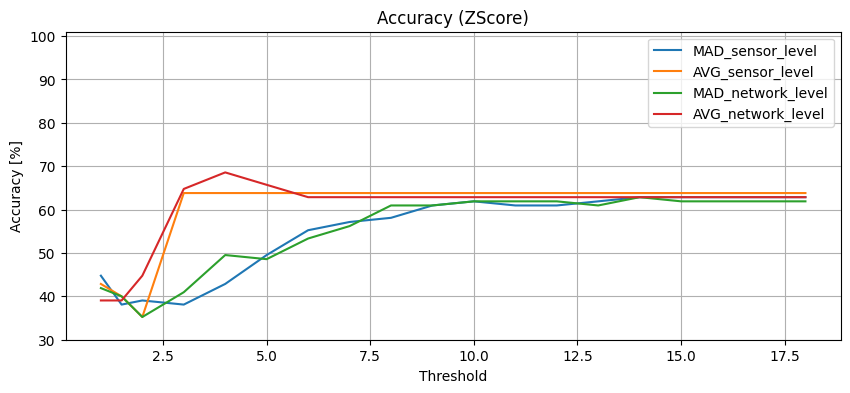

In [4]:
from matplotlib import pyplot as plt


def draw_results(final_results, title):
    print(f"Plotting {title}")
    plt.figure(figsize=(10, 4))

    for result in final_results:
        name = result[0][0]
        plt.plot([x[1] for x in result], [x[2] for x in result], label=name)

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy [%]')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.ylim(30, 101)
    plt.show()


draw_results(final_results, "Accuracy (ZScore)")


In [8]:
from detectors.pseudo_periodic import PseudoPeriodicDetector
import pandas as pd

column = PM10
sensor_data = datas[0]
thresholds = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12]
windows = [1,2,3,4,8,12]
histories = [3, 5, 7, 10, 14]
final_results = []

#single sensor detection


def debug_print(threshold, correct_anomaly, anomaly, normal, history, window, zscore, level):
    # print(
    #     f'    [Threshold: {threshold}][History: {history}][Window: {window}] Anomaly: {correct_anomaly}/{anomaly} ({round(correct_anomaly / anomaly * 100, 2)}) | Normal {round(correct_normal / normal * 100, 2)} | {round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)}%')
    acc = round((correct_anomaly + correct_normal) / (anomaly + normal) * 100, 2)
    if acc > 65.:
        print(f' {zscore} & {level} & {threshold} & {history} & {window} & {acc} \\ ')
        print('\hline')

    # counted_values = Counter(wrong_predicted)
    # # Print the counts
    # for value, count in counted_values.items():
    #     print(f"{value}: {count}")



name = 'PERIODIC_MAD sensor level'
zscore = "MAD"
lvl = "Sensor"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            data_length = 0
            correct_anomaly = 0
            correct_normal = 0
            anomaly = 0
            normal = 0
            for dataframe, label in test_data:
                if not dataframe.empty:
                    data_length += 1
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_mad(destroyed, column, start_time, end_time,
                                                                               time_step_in_hours=4,
                                                                               threshold=threshold,
                                                                               max_depth_in_days=history)
                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            correct_anomaly += 1
                    if label.value == 0:
                        normal += 1
                        if (len(outliers) < 5):
                            correct_normal += 1
    
            debug_print(threshold, correct_anomaly, anomaly, normal, history, window, zscore, lvl)
        print()

name = 'PERIODIC_AVG sensor level'
zscore = "AVG"
lvl = "Sensor"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            data_length = 0
            correct_anomaly = 0
            correct_normal = 0
            anomaly = 0
            normal = 0
    
            for dataframe, label in test_data:
                if not dataframe.empty:
                    data_length += 1
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_avg(destroyed, column, start_time, end_time,
                                                                                time_step_in_hours=4,
                                                                               threshold=threshold,
                                                                               max_depth_in_days=history)
                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            correct_anomaly += 1
                    if label.value == 0:
                        normal += 1
                        if (len(outliers) < 5):
                            correct_normal += 1
    
            debug_print(threshold, correct_anomaly, anomaly, normal, history, window, zscore, lvl)
        print()

name = 'PERIODIC_MAD network level'
zscore = "MAD"
lvl = "Network"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            data_length = 0
            correct_anomaly = 0
            correct_normal = 0
            anomaly = 0
            normal = 0
            for dataframe, label in test_data:
                if not dataframe.empty:
                    data_length += 1
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_mad_network_level(datas, destroyed, column,
                                                                                             start_time, end_time,
                                                                                              time_step_in_hours=4,
                                                                                             threshold=threshold,
                                                                                             max_depth_in_days=history)
                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            correct_anomaly += 1
                    if label.value == 0:
                        normal += 1
                        if (len(outliers) < 5):
                            correct_normal += 1
    
            debug_print(threshold, correct_anomaly, anomaly, normal, history, window, zscore, lvl)
        print()

name = 'PERIODIC_AVG network level'
zscore = "AVG"
lvl = "Network"
print(f"{name}:")
for window in windows:
    for history in histories:
        for threshold in thresholds:
            data_length = 0
            correct_anomaly = 0
            correct_normal = 0
            anomaly = 0
            normal = 0
            for dataframe, label in test_data:
                if not dataframe.empty:
                    data_length += 1
                    start_time = dataframe[TIMESTAMP].min()
                    end_time = dataframe[TIMESTAMP].max()
                    destroyed = sensor_data.copy()
                    destroyed.name = sensor_data.name
                    destroyed.update(dataframe)
                    outliers = PseudoPeriodicDetector().detect_by_periodic_avg_network_level(datas, destroyed, column,
                                                                                             start_time, end_time,
                                                                                             time_step_in_hours=4,
                                                                                             threshold=threshold,
                                                                                             max_depth_in_days=history)
                    if label.value > 0:
                        anomaly += 1
                        if (len(outliers) > 5):
                            correct_anomaly += 1
                    if label.value == 0:
                        normal += 1
                        if (len(outliers) < 5):
                            correct_normal += 1
    
            debug_print(threshold, correct_anomaly, anomaly, normal, history, window, zscore, lvl)
        print()




PERIODIC_MAD sensor level:
 MAD & Sensor & 8 & 5 & 1 & 67.62 \ 
\hline
 MAD & Sensor & 9 & 5 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 10 & 5 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 4 & 7 & 1 & 65.71 \ 
\hline
 MAD & Sensor & 7 & 7 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 8 & 7 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 9 & 7 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 10 & 7 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 5 & 10 & 1 & 67.62 \ 
\hline
 MAD & Sensor & 6 & 10 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 7 & 10 & 1 & 68.57 \ 
\hline
 MAD & Sensor & 8 & 10 & 1 & 67.62 \ 
\hline
 MAD & Sensor & 9 & 10 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 10 & 10 & 1 & 65.71 \ 
\hline
 MAD & Sensor & 5 & 14 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 6 & 14 & 1 & 67.62 \ 
\hline
 MAD & Sensor & 7 & 14 & 1 & 68.57 \ 
\hline
 MAD & Sensor & 8 & 14 & 1 & 67.62 \ 
\hline
 MAD & Sensor & 9 & 14 & 1 & 66.67 \ 
\hline
 MAD & Sensor & 10 & 14 & 1 & 65.71 \ 
\hline
 MAD & Sensor & 11 & 14 & 1 & 65.71 \ 
\hline
 MAD & Sensor & 8 & 5 & 2 & 67.